# Get extra text features for movies

In [59]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

from globals import item_metadata_file, imdb_path, movielens_path

## Get text plots from public API

In [4]:
# load metadata
metadata = pd.read_hdf(item_metadata_file + '.h5', key='metadata')

In [6]:
metadata.index

Index(['tt0180093', 'tt0118694', 'tt0203009', 'tt0211915', 'tt0287467',
       'tt0167261', 'tt0317248', 'tt0266543', 'tt0325980', 'tt0335266',
       ...
       'tt5095030', 'tt1142988', 'tt0425123', 'tt1059786', 'tt1588173',
       'tt2293640', 'tt1855199', 'tt0780521', 'tt1655442', 'tt0335119'],
      dtype='object', length=1073)

In [ ]:
plots = {}

In [38]:
def get_plot(imdbID, api_key='2438a607'):  # keys: a2ed3a33, 51ed9c6b, 2438a607
    url = f'http://www.omdbapi.com/?i={imdbID}&plot=full&apikey={api_key}'
    resp = requests.get(url=url)
    data = resp.json()
    if data['Response'] != 'False':
        return data['Plot']
    else:
        return ''

In [39]:
for imdbID in tqdm(metadata.index, total=len(metadata.index)):
    if imdbID not in plots or plots[imdbID] == '':
        plots[imdbID] = get_plot(imdbID)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [00:17<00:00, 61.55it/s]


In [40]:
plots_df = pd.Series(plots)
plots_df

tt0180093    Sara Goldfarb (Ellen Burstyn) is a retired wid...
tt0118694    Set in Hong Kong, 1962, Chow Mo-Wan is a newsp...
tt0203009    The year is 1899, and Christian, a young Engli...
tt0211915    Amélie is a story about a girl named Amélie wh...
tt0287467    After a chance encounter at a theater, two men...
                                   ...                        
tt2293640    Ever since the dawn of time, the Minions have ...
tt1855199    In South Central Los Angeles, street cops Bria...
tt0780521    A modern day retelling of the classic story Th...
tt1655442    Outside a movie premiere, enthusiastic fan Pep...
tt0335119    This film, adapted from a work of fiction by a...
Length: 1073, dtype: object

<AxesSubplot:>

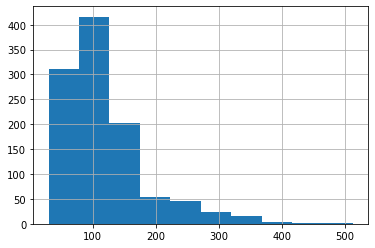

In [45]:
plots_df.apply(lambda x: len(x.split())).hist()

In [43]:
plots_df.to_csv('../data/text_plots.csv', header=None)

## Recover titles from IMDb

In [50]:
def load_imdb_titles(imdbIDs, usecols=('tconst', 'primaryTitle', 'genres', 'startYear')):
    df = pd.read_csv(imdb_path + 'title.basics.tsv', index_col='tconst', sep='\t', usecols=usecols, encoding='utf-8', keep_default_na=False, na_values=['\\N']).loc[imdbIDs]
    return df

df = load_imdb_titles(plots_df.index)

C:\Users\mikem\AppData\Local\Temp/ipykernel_4332/2206609681.py:5: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_imdb_titles(plots_df.index)


## Recover genome tags with their names

In [64]:
# load genome tags
def load_genome_tags(imdbIDs):
    # load genome tags supplied with movielens
    genometags = pd.read_csv(movielens_path + 'genome-scores.csv',
                             index_col='movieId',
                             usecols=['movieId', 'tagId', 'relevance'],
                             dtype={'movieId': np.int32, 'tagId': np.int32, 'relevance': np.float64})
    genometags = genometags.pivot_table('relevance', index='movieId', columns='tagId')
    
    genomenames = pd.read_csv(movielens_path + 'genome-tags.csv',
                             index_col='tagId',
                             dtype={'tagId': np.int32, 'tag': str})

    # change movieId to IMDb ID, link movieIds with imdbIds
    links = pd.read_csv(movielens_path + 'links.csv',
                        index_col='movieId',
                        usecols=['movieId', 'imdbId'],
                        dtype={'movieId': np.int32, 'imdbId': 'string'})
    genometags.index = 'tt' + genometags.index.map(links['imdbId'])
    genometags.rename({c: genomenames.loc[c]['tag'] for c in genometags.columns.tolist()}, inplace=True, axis=1)   # needed for concat to work later
    
    return genometags.loc[imdbIDs]

genome = load_genome_tags(plots_df.index)
genome

tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
tt0180093,0.02175,0.01775,0.03025,0.05200,0.07750,0.07500,0.05050,0.26975,0.12500,0.03000,...,0.10325,0.01575,0.01550,0.17475,0.25575,0.18425,0.03525,0.01700,0.08775,0.02225
tt0118694,0.02125,0.01950,0.16625,0.15175,0.08775,0.07450,0.55700,0.16375,0.02200,0.13450,...,0.04550,0.02550,0.01675,0.11725,0.20100,0.12100,0.75800,0.01150,0.06575,0.01750
tt0203009,0.03450,0.02825,0.16725,0.14150,0.09850,0.08100,0.05225,0.12400,0.04000,0.19050,...,0.06550,0.03150,0.01500,0.26750,0.28400,0.11100,0.05575,0.01425,0.09600,0.01975
tt0211915,0.02375,0.01975,0.15650,0.10925,0.12925,0.12400,0.07450,0.22375,0.10375,0.08625,...,0.07375,0.02675,0.01950,0.11725,0.20550,0.11800,0.10725,0.01800,0.09475,0.02525
tt0287467,0.02175,0.02025,0.08400,0.15050,0.08175,0.06950,0.05475,0.21100,0.04650,0.06300,...,0.04725,0.02575,0.01950,0.11425,0.41250,0.18575,0.06400,0.02050,0.07325,0.01825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2293640,0.03575,0.03075,0.03825,0.03875,0.04825,0.02700,0.11925,0.07125,0.00975,0.03825,...,0.05450,0.02075,0.01050,0.01100,0.17775,0.04375,0.02100,0.00900,0.12275,0.01750
tt1855199,0.02775,0.02725,0.02950,0.04600,0.06275,0.07400,0.05150,0.30375,0.07575,0.03100,...,0.07925,0.02025,0.01900,0.03875,0.27700,0.22575,0.02650,0.01700,0.10550,0.02250
tt0780521,0.03050,0.02900,0.05875,0.33500,0.16600,0.03500,0.03275,0.08900,0.02525,0.04575,...,0.05725,0.02350,0.01350,0.02225,0.15550,0.04800,0.02100,0.01250,0.10550,0.01975
tt1655442,0.02450,0.02250,0.15275,0.87575,0.86750,0.44625,0.11975,0.30575,0.08875,0.11525,...,0.07650,0.03175,0.01800,0.03850,0.17525,0.16225,0.03550,0.01525,0.09200,0.02150


### Convert numerical tags to categorical labels by applying a threshold

In [99]:
# source: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas
threshold = 0.7
genome['tags'] = ''                # new str col
for col_name in genome.columns:
    if col_name == 'tags': continue
    genome.loc[genome[col_name] >= threshold, 'tags'] = genome['tags'] + ' ' + col_name
genome['tags']

tt0180093     adaptation adapted from:book addiction atmosp...
tt0118694     adultery affectionate art house artistic atmo...
tt0203009     beautiful beautifully filmed cinematography c...
tt0211915     affectionate amazing cinematography artistic ...
tt0287467     almodovar beautifully filmed breathtaking cin...
                                   ...                        
tt2293640     adventure animation children comedy computer ...
tt1855199     action brutality chase corruption crime death...
tt0780521     animated animation cartoon computer animation...
tt1655442     1920s 1930s affectionate amazing photography ...
tt0335119     adaptation adapted from:book art artist artis...
Name: tags, Length: 1073, dtype: object

<AxesSubplot:>

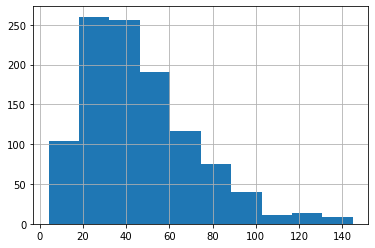

In [96]:
genome['tags'].apply(lambda x: len(x.split())).hist()

## Save everything into one dataframe

In [103]:
# Add text plot
df['plot'] = plots_df

# Add genome tags
df['tags'] = genome['tags']

In [106]:
df

,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,tags,plot
tt0180093,Requiem for a Dream,Requiem for a Dream,2000.0,102.0,Drama,adaptation adapted from:book addiction atmosp...,Sara Goldfarb (Ellen Burstyn) is a retired wid...
tt0118694,In the Mood for Love,Fa yeung nin wah,2000.0,98.0,"Drama,Romance",adultery affectionate art house artistic atmo...,"Set in Hong Kong, 1962, Chow Mo-Wan is a newsp..."
tt0203009,Moulin Rouge!,Moulin Rouge!,2001.0,127.0,"Drama,Musical,Romance",beautiful beautifully filmed cinematography c...,"The year is 1899, and Christian, a young Engli..."
tt0211915,Amélie,Le fabuleux destin d'Amélie Poulain,2001.0,122.0,"Comedy,Romance",affectionate amazing cinematography artistic ...,Amélie is a story about a girl named Amélie wh...
tt0287467,Talk to Her,Hable con ella,2002.0,112.0,"Drama,Mystery,Romance",almodovar beautifully filmed breathtaking cin...,"After a chance encounter at a theater, two men..."
...,...,...,...,...,...,...,...
tt2293640,Minions,Minions,2015.0,91.0,"Adventure,Animation,Comedy",adventure animation children comedy computer ...,"Ever since the dawn of time, the Minions have ..."
tt1855199,End of Watch,End of Watch,2012.0,109.0,"Action,Adventure,Crime",action brutality chase corruption crime death...,"In South Central Los Angeles, street cops Bria..."
tt0780521,The Princess and the Frog,The Princess and the Frog,2009.0,97.0,"Adventure,Animation,Comedy",animated animation cartoon computer animation...,A modern day retelling of the classic story Th...
tt1655442,The Artist,The Artist,2011.0,100.0,"Comedy,Drama,Romance",1920s 1930s affectionate amazing photography ...,"Outside a movie premiere, enthusiastic fan Pep..."


In [107]:
df.to_csv('../data/movie_info.csv')